In [30]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download phylake1337/fire-dataset

 98% 379M/387M [00:03<00:00, 150MB/s]
100% 387M/387M [00:03<00:00, 119MB/s]


In [5]:
!unzip -qq fire-dataset.zip

In [6]:
! mkdir df
!cp -r fire_dataset/fire_images/* df
! cp -r fire_dataset/non_fire_images/* df

### Data Preprocessing

In [5]:
fire_dir = glob.glob('fire_dataset/fire_images/*.png')
non_fire_dir = glob.glob('fire_dataset/non_fire_images/*.png')
fire_dir

['fire_dataset/fire_images/fire.59.png',
 'fire_dataset/fire_images/fire.601.png',
 'fire_dataset/fire_images/fire.433.png',
 'fire_dataset/fire_images/fire.121.png',
 'fire_dataset/fire_images/fire.671.png',
 'fire_dataset/fire_images/fire.685.png',
 'fire_dataset/fire_images/fire.156.png',
 'fire_dataset/fire_images/fire.249.png',
 'fire_dataset/fire_images/fire.382.png',
 'fire_dataset/fire_images/fire.418.png',
 'fire_dataset/fire_images/fire.459.png',
 'fire_dataset/fire_images/fire.633.png',
 'fire_dataset/fire_images/fire.322.png',
 'fire_dataset/fire_images/fire.722.png',
 'fire_dataset/fire_images/fire.507.png',
 'fire_dataset/fire_images/fire.327.png',
 'fire_dataset/fire_images/fire.664.png',
 'fire_dataset/fire_images/fire.506.png',
 'fire_dataset/fire_images/fire.739.png',
 'fire_dataset/fire_images/fire.470.png',
 'fire_dataset/fire_images/fire.711.png',
 'fire_dataset/fire_images/fire.242.png',
 'fire_dataset/fire_images/fire.536.png',
 'fire_dataset/fire_images/fire.377

In [6]:
fire_df = []
non_fire_df = []
for i in fire_dir:
    fire_df.append([i,'fire'])
for j in non_fire_dir:
    non_fire_df.append([j,'non-fire'])
df = fire_df + non_fire_df
random.shuffle(df)

In [74]:
data_df = pd.DataFrame(df, columns = ['path','label'])
print (data_df)

                    path
0    df/non_fire.240.png
1        df/fire.563.png
2        df/fire.360.png
3        df/fire.402.png
4        df/fire.316.png
..                   ...
994   df/non_fire.90.png
995      df/fire.229.png
996      df/fire.456.png
997      df/fire.743.png
998      df/fire.754.png

[999 rows x 1 columns]


In [37]:
! rm -rf fire_dataset/

In [37]:
import os, shutil, pathlib

original_dir = pathlib.Path("df")
#make_subset("train", start_index=1, end_index=300)
train_dir = os.path.join(original_dir)
validation_dir = os.path.join(original_dir)

In [38]:
os.listdir(train_dir)

['non_fire.240.png',
 'fire.563.png',
 'fire.360.png',
 'fire.402.png',
 'fire.316.png',
 'non_fire.38.png',
 'fire.124.png',
 'fire.146.png',
 'fire.162.png',
 'fire.604.png',
 'fire.232.png',
 'fire.211.png',
 'non_fire.203.png',
 'non_fire.100.png',
 'fire.583.png',
 'fire.133.png',
 'non_fire.125.png',
 'fire.575.png',
 'non_fire.65.png',
 'non_fire.70.png',
 'fire.180.png',
 'fire.138.png',
 'non_fire.128.png',
 'fire.340.png',
 'fire.163.png',
 'fire.609.png',
 'fire.458.png',
 'fire.291.png',
 'non_fire.191.png',
 'fire.536.png',
 'non_fire.105.png',
 'fire.177.png',
 'fire.593.png',
 'fire.279.png',
 'fire.398.png',
 'fire.495.png',
 'fire.716.png',
 'fire.282.png',
 'fire.292.png',
 'fire.644.png',
 'fire.556.png',
 'fire.493.png',
 'fire.98.png',
 'non_fire.17.png',
 'fire.260.png',
 'fire.23.png',
 'non_fire.130.png',
 'fire.112.png',
 'non_fire.6.png',
 'fire.328.png',
 'fire.348.png',
 'fire.705.png',
 'fire.255.png',
 'fire.330.png',
 'fire.187.png',
 'fire.25.png',
 'fir

In [39]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [40]:
IMG_SHAPE = 256

In [52]:
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True)

In [54]:
train_generator = datagen.flow_from_directory(batch_size=20,
                                               directory="fire_dataset",
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary')

Found 999 images belonging to 2 classes.


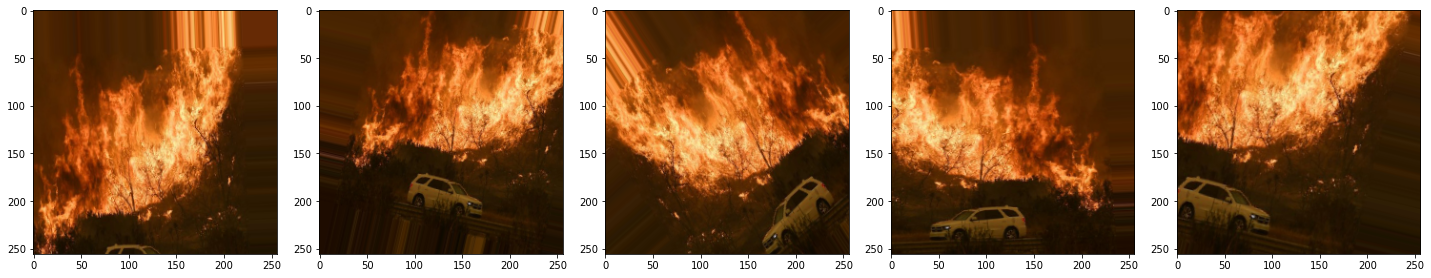

In [55]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
validation_generator = datagen.flow_from_dataframe(data_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(256,256),
                                                   class_mode='binary',
                                                   subset='validation')

In [68]:
image_gen_val = ImageDataGenerator(rescale=1./255)

validation_generator = image_gen_val.flow_from_directory(batch_size=20,
                                                 directory="fire_dataset",
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 999 images belonging to 2 classes.


### InceptionV3

In [ ]:
inception_v3 = InceptionV3(input_shape=(256,256,3),
                           weights='imagenet',
                           include_top=False)
inception_v3.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


**Definindo o Modelo**

In [56]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu', input_shape=(256,256,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

#x = layers.Flatten()(inception_v3.output)
#x = layers.BatchNormalization()(x)
#x = layers.Dense(1024,activation='relu')(x)
#x = layers.Dropout(0.2)(x)                  
#x = layers.Dense(1,activation='sigmoid')(x)           

#model1 = Model(inception_v3.input, x) 


In [64]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])


**Compilando o Modelo**

In [65]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [66]:
model.summary()   

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)      

In [ ]:
history = model.fit_generator(train_generator,
                               epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


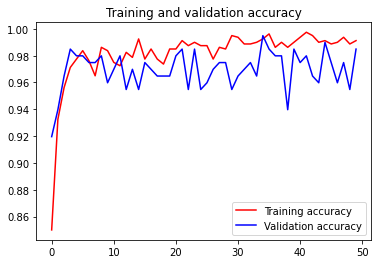

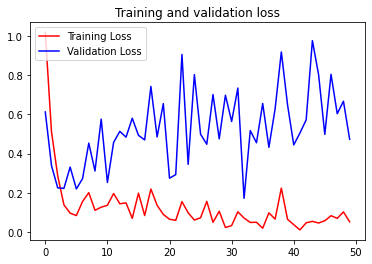

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc1 = model1.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

7/7 [==============================] - 8s 1s/step - loss: 0.7592 - acc: 0.9749
validation_accuracy: 0.9748743772506714


### EfficientNet B0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
efficientnet_b0 = EfficientNetB0(include_top=False,
                             weights="imagenet",
                             input_shape=(256,256,3))
efficientnet_b0.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b0.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model2 = Model(efficientnet_b0.input, x) 

model2.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model2.fit_generator(train_generator,
                               epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc2 = model2.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc2))

### EfficientNet B7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
efficientnet_b7 = EfficientNetB7(include_top=False,
                                 weights="imagenet",
                                 input_shape=(256,256,3))
efficientnet_b7.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b7.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model3 = Model(efficientnet_b7.input, x) 

model3.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model3.fit_generator(train_generator,epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc3 = model3.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc3))

### Model Comparison

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [val_acc1,val_acc2,val_acc3]
model = ['InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()